# No Preprocessing: Cats vs Dogs: VGG19

Using the Intel Images dataset, we will read the data files into memory as-is. The only processing that will be performed is reshaping the dataset into squares, since the neural network structure used requires the inputs to be of fixed dimensions. We will feed the dataset into a customly defined Convolutional Neural Network model, which will be trained for 25 epochs. This is intended to act as a baseline for this model/dataset, showing how the network performs without any regularization schemes. 

## Imports

Before we begin, we need to import the necessary python packages and appropriately configure the tensorflow gpu enviornment for use with the correct GPU on this system (RTX 2070 in GPU slot 0). 

* **`numpy`:** used for matrix operations, storing the pixel data of the images while working
* **`pandas`:** used for tabular organization of the results for storing in a formatted csv style for later evaluation in another notebook
* **`matplotlib.pyplot`:** used for data visualization for the model performance after training
* **`cv2`:** OpenCV for python, used for reading and manipulating the image files from the dataset before storing in working memory.
* **`os`:** used for streamlined access of the filesystem for determining the paths to each of the data files
* **`tensorflow.keras`:** used for model creation, compiling, and training. The GPU variant of tensorflow was used; this program has not been tested for systems without access to the GPU acclerations. 
* **`sklearn.utils.shuffle`:** used for an efficient shuffling of the X and y datasets together. 
* **`timeit.default_timer`:** used for timing the overhead and training runtime performance of the model when no preprocessing is performed

In [1]:
# === Imports === #
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow    import keras
from sklearn.utils import shuffle
from timeit        import default_timer


# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Total Times Log === #
times = list( )

## Determine Train/Test Data Files

First, we need to determine the files which are to be used for training and validation. In order to do this, we will use our knowledge of the filesystem structure for the project, as well as the os listdir function to produce two lists: one of the filepaths used for the training data, and one of the filepaths used for the validation data. Finally, the first ten items of each list are printed to verify the success of the file list creation. 

In [2]:
# === Setup Variables === #
data_root_dir   = 'Dataset/Dog_vs_Cat/'
data_classes    = os.listdir( data_root_dir + 'training_set/' )
training_subdir = 'training_set/'
testing_subdir  = 'test_set/'
training_files  = [ ]
testing_files   = [ ]


# === For Each Class, Add Files to Appropriate List === #
for data_class in data_classes:
    for f in os.listdir( data_root_dir + training_subdir + data_class + '/' ):
        training_files.append( data_root_dir + training_subdir + data_class + '/' + f )
    for f in os.listdir( data_root_dir + testing_subdir + data_class + '/' ):
        testing_files.append( data_root_dir + testing_subdir + data_class + '/' + f )

    
# === Show First 10 of Each to Prove Success === #
print( 'Training Set:\n{}'.format( training_files[:10] ) )
print( '\nTesting Set: \n{}'.format( testing_files[:10] ) )

Training Set:
['Dataset/Dog_vs_Cat/training_set/cats/cat.1.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.10.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.100.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1000.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1001.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1002.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1003.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1004.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1005.jpg', 'Dataset/Dog_vs_Cat/training_set/cats/cat.1006.jpg']

Testing Set: 
['Dataset/Dog_vs_Cat/test_set/cats/cat.4001.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4002.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4003.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4004.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4005.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4006.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4007.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4008.jpg', 'Dataset/Dog_vs_Cat/test_set/cats/cat.4009.jpg', 'Dat

## Get Image Data & Label from File Names

Using our two file lists, we need to read the image data into working memory for the model to use in the training process. Since our model requires all training and validation data to be of the same shape, reshaping the image as its read will be the only transformation performed on the data. Analyzing the dataset showed that the average training image shape was `(360,400)`. In order to maintain the integrity of the experiment, all images were manually reshaped to be a square of this larger dimension `(400,400)`. We keep the read images as 8-bit integers, without regularization, and we keep the RGB color scheme of the images. 

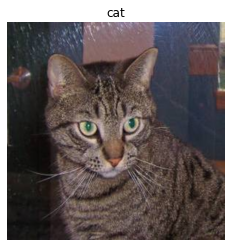

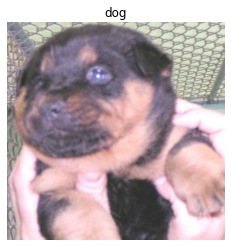

In [3]:
# ================================================================================
# FUNCTION: files_to_Xy( file_list , desired_shape )
# ================================================================================
# 
# Input: 
#   - file_list: list of filepaths to be read (as generated in the previous cell)
#   - desired_shape (optional): dimensions to transform the image data into
#        * default = (400,400,3): a 400x400 RGB image
#
# Output:
#   - Numpy array of shape (n,h,w,c) containing every image present in the list
#        * n = number of images listed to be read
#        * h = first dimension of desired_shape: height of image 
#        * w = second dimension of desired_shape: width of image
#        * c = third dimension of desired_shape: number of channels in the image (RGB=3)
#
# Task:
#   1. Iterate over the file list
#   2. Parse the y label for the image out of the file path
#   3. Use OpenCV (cv2) to read the image data and reshape appropriately
#   4. store the image data/label into numpy arrays of the desired shape
#   5. return the populated X and y after finished iterating
#
# ================================================================================
def files_to_Xy( file_list , desired_shape=(400,400,3) ):
    
    # === Setup Variables === #
    X = np.empty( (len( file_list ), desired_shape[0], desired_shape[1], desired_shape[2] ) , dtype=np.uint8 )
    y = np.empty( len( file_list ) , dtype=object )
    
    # === Iterate Files === #
    for i in range( len( file_list ) ):
        y[i] = file_list[i][ file_list[i].rfind('/')+1:file_list[i].index( '.' ) ]  # either "dog" or "cat"
        X[i] = cv2.cvtColor( 
                    cv2.resize( 
                        cv2.imread( file_list[i] , cv2.IMREAD_UNCHANGED ), 
                        ( desired_shape[0] , desired_shape[1] ) 
                    ), 
                    cv2.COLOR_BGR2RGB )  # read as rgb instead of bgr
        
    # === Return Results === #
    return X , y



# ================================================================================
# FUNCTION: show_image( X , y , idx )
# ================================================================================
#
# Input:
#   - X: numpy array containing the image data
#   - y: numpy array containing the corresponding class labels
#   - idx: index of the image to be shown
#
# Output:
#   - no return
#   - matplotlib imshow figure displayed
#
# Task:
#   1. using matplotlib.pyplot.imshow() to display the specified image
#
# Note:
#   - This function is not necessary for program completion, but it serves as a 
#     utility function to help demonstrate the success of the other necessary 
#     functions. 
#
# ================================================================================
def show_image( X , y , idx ):
    plt.figure( )
    plt.axis( 'off' )
    plt.imshow( X[idx] )
    plt.title( y[idx] )
    plt.show( )
        
        
        
# === Use Function to Get Train/Test Data === #
start             = default_timer( )
X_train , y_train = files_to_Xy( training_files )
X_test  , y_test  = files_to_Xy( testing_files  )
end               = default_timer( )
times.append( { 'Event': 'Load/Process Dataset' , 'Time (sec)': end - start } )



# === Show First and Last Images and Classes as Proof === #
show_image( X_train , y_train , 0 )
show_image( X_train , y_train , y_train.shape[0] - 1 )

## Shuffle the Training Data

Shuffling the training data is an important step to be performed before training any model. This helps to allow fairness in the training, and ensure the model is learning most effectively without encountering any biases due to ordering (for example, all cats are listed before all dogs currently, so the model may overfit to dogs before learning anything about cats).

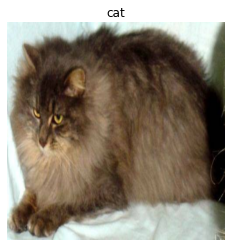

In [4]:
# === Shuffle X and y Together === #
X_train , y_train = shuffle( X_train , y_train )


# === Prove by Printing First Again to show it's Different === #
show_image( X_train , y_train , 0 )

## Convert Classes from Strings to Integers

Keras models don't handle categorical classes as well as numerical classes -- especially fora  binary classifier. Because of this, instead of having two class categories, we will translate the two possible classes to either a zero or a one to let the numerical output of the model specify the predicted class of the data. 

    Cat --> 0
    Dog --> 1

This translation is performed against both the training and validation labels. 

In [5]:
# === Key to Translate in Either Direction
label_keys = {
    'cat' : 0,
    'dog' : 1,
    0     : 'cat',
    1     : 'dog'
}

# === Update Training y === #
y_train[y_train=='cat'] = 0
y_train[y_train=='dog'] = 1
y_train = y_train.astype( X_train.dtype )

# === Update Testing y === #
y_test[y_test=='cat'] = 0
y_test[y_test=='dog'] = 1
y_test = y_test.astype( X_test.dtype )

# === Prove Success === #
y_train

array([0, 1, 0, ..., 0, 1, 1], dtype=uint8)

## Create Layers for Model

We will be using a convolutional neural network, whose layers are specified to resemble the VGG19 model architecture. Consisting of 5 convolution blocks: 2x64, 2x128, 4x256, 4x512, 4x512. Each convolution block has a 2x2 pooling layer at the end of the block. After the five convolution blocks, the model is flattened, connected to a 1024 depth dense layer, then a dropout of 0.3, then a 64 depth dense layer, and finally a 1-depth dense layer for output. the ReLU activation function is used for all relevant layers with the exception of the output layer, which uses the sigmorid activation since this is a binary classification problem. 

In [6]:
model_layers = [
    keras.Input( shape=X_train[0].shape , name='Input_Layer' ),
    
    keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_1' , padding='same' ),
    keras.layers.Conv2D( 64 , kernel_size=(3,3) , activation='relu' , name='Conv_1_2' , padding='same' ),
    keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_1_Pooling' ),
    
    keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_1' , padding='same' ),
    keras.layers.Conv2D( 128 , kernel_size=(3,3) , activation='relu' , name='Conv_2_2' , padding='same' ),
    keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_2_Pooling' ),
    
    keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_1' , padding='same' ),
    keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_2' , padding='same' ),
    keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_3' , padding='same' ),
    keras.layers.Conv2D( 256 , kernel_size=(3,3) , activation='relu' , name='Conv_3_4' , padding='same' ),
    keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_3_Pooling' ),
    
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_1' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_2' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_3' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_4_4' , padding='same' ),
    keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_4_Pooling' ),
    
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_1' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_2' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_3' , padding='same' ),
    keras.layers.Conv2D( 512 , kernel_size=(3,3) , activation='relu' , name='Conv_5_4' , padding='same' ),
    keras.layers.MaxPooling2D( pool_size=(2,2) , name='Conv_5_Pooling' ),
    
    keras.layers.Flatten( ),
    
    keras.layers.Dense( 1024 , activation='relu' ),
    keras.layers.Dropout( 0.3 ),
    
    keras.layers.Dense( 64 , activation='relu' ),
    keras.layers.Dropout( 0.3 ),
    
    keras.layers.Dense( 1 , activation='sigmoid' )
]

## Construct the Model

First we will use the list of layers we defined as input to the constructor of a `keras.Sequential` object, which will contain our model. After the model initializes with our specified layers, we will define a custom optimizer -- a variant of the built-in `adam` optimizer with a lower learning rate (which has been tuned over several runs of the program to determine one which produces stable results, as the default would over fit too quickly). Finally, we compile the model to our specifications and summarize the model to show that it compiled successfully. 

In [7]:
# === Construct Model from Layers === #
model = keras.Sequential( layers=model_layers )

# === Compile the Model with Custom Learning Rate === #
epochs    = 25
rate      = len( model_layers ) / model.count_params( )
decay     = rate / epochs
optimizer = keras.optimizers.Adam( lr=rate , decay=decay )
model.compile( loss="binary_crossentropy" , optimizer=optimizer , metrics=["accuracy"] )

# === Summary to Show Successfil Compilation === #
model.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1_1 (Conv2D)            (None, 400, 400, 64)      1792      
_________________________________________________________________
Conv_1_2 (Conv2D)            (None, 400, 400, 64)      36928     
_________________________________________________________________
Conv_1_Pooling (MaxPooling2D (None, 200, 200, 64)      0         
_________________________________________________________________
Conv_2_1 (Conv2D)            (None, 200, 200, 128)     73856     
_________________________________________________________________
Conv_2_2 (Conv2D)            (None, 200, 200, 128)     147584    
_________________________________________________________________
Conv_2_Pooling (MaxPooling2D (None, 100, 100, 128)     0         
_________________________________________________________________
Conv_3_1 (Conv2D)            (None, 100, 100, 256)     2

## Train the Model

Now that our model is compiled and our dataset is in memory, it's time to train the model. The process is relatively straightforward. We train for 25 epochs (the results of several prior tests determined that the model would coverge most commonly by the 25th epoch). We also opted to use a batch size of 16 in order to balance the training time with model performance. 

In [8]:
# === Train the Model to Our Data for 25 Epochs === #
start = default_timer( )
history = model.fit( X_train,
                     y_train,
                     epochs=epochs,
                     batch_size=16,
                     validation_data=( X_test , y_test ) )
end = default_timer( )
times.append( { 'Event': 'Training' , 'Time (sec)': end - start } )

# === Extract History Values for Later Plotting === #
history_dict = history.history

Train on 8000 samples, validate on 2000 samples
Epoch 1/25
8000/8000 [==============================] - 311s 39ms/sample - loss: 0.6909 - accuracy: 0.5280 - val_loss: 0.6837 - val_accuracy: 0.5740
Epoch 2/25
8000/8000 [==============================] - 314s 39ms/sample - loss: 0.6820 - accuracy: 0.5629 - val_loss: 0.6726 - val_accuracy: 0.6145
Epoch 3/25
8000/8000 [==============================] - 311s 39ms/sample - loss: 0.6703 - accuracy: 0.5928 - val_loss: 0.6577 - val_accuracy: 0.6405
Epoch 4/25
8000/8000 [==============================] - 311s 39ms/sample - loss: 0.6577 - accuracy: 0.6087 - val_loss: 0.6449 - val_accuracy: 0.6355
Epoch 5/25
8000/8000 [==============================] - 311s 39ms/sample - loss: 0.6454 - accuracy: 0.6265 - val_loss: 0.6334 - val_accuracy: 0.6485
Epoch 6/25
8000/8000 [==============================] - 311s 39ms/sample - loss: 0.6350 - accuracy: 0.6371 - val_loss: 0.6281 - val_accuracy: 0.6345
Epoch 7/25
8000/8000 [==============================] - 31

## Visualize Loss

This next cell shows a plot of the training and validation loss for the model (the exact results are saved in a future cell for later processing in another notebook).

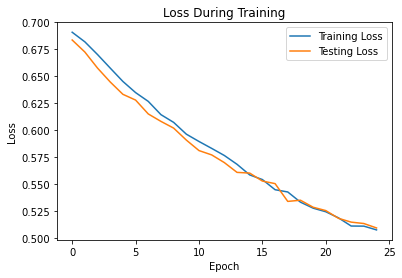

In [9]:
# === Plot the Data === #
plt.plot( history_dict['loss']     , label='Training Loss' )
plt.plot( history_dict['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Visualize Accuracy

This next cell shows a plot of the training and validation accuracy for the model (the exact results are saved in a future cell for later processing in another notebook.

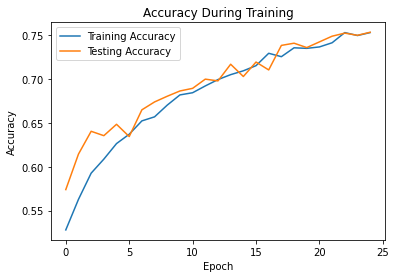

In [10]:
# === Plot the Data === #
plt.plot( history_dict['accuracy']     , label='Training Accuracy' )
plt.plot( history_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

## Save the Model 

Now that the model has been fully trained, we want to save the learned weights in order to be further evaluated later if needed. 

In [11]:
# === Save for Future Evaluation === #
model.save( 'No_Preprocess_Results/vgg19_catvdog_model.h5' )

## Display Runtimes

We will show the measured preprocessing overhead time and the training time of this program in order to gain an understanding of the behavior of this baseline application. These resutls are saved in a future slide for later processing in a different notebook. 

In [12]:
for t in times:
    print( '{}: {}s'.format( t['Event'] , round( t['Time (sec)'] , 4 ) ) )

Load/Process Dataset: 18.9993s
Training: 7796.2783s


## Save Time Data

The above data is converted into a pandas DataFrame for saving into a formatted CSV file. This csv file will be used for processing in a different notebook. 

In [13]:
time_data  = {
    'Event': [t['Event'] for t in times],
    'Time (sec)': [t['Time (sec)'] for t in times]
}
time_table = pd.DataFrame( time_data )
time_table.to_csv( 'No_Preprocess_Results/vgg19_catvdog_times.csv' , index=False )
time_table.head( )

,Event,Time (sec)
0,Load/Process Dataset,18.999322
1,Training,7796.278304


## Save Training/Validation Data

Finally, construct a pandas dataframe of the training loss, validation loss, training accuracy, and validation accuracy at each epoch during training. These values are saved for processing in a different notebook. 

In [14]:
model_data = {
    'Epoch': [i+1 for i in range(25)],
    'Training Accuracy': history_dict['accuracy'],
    'Validation Accuracy': history_dict['val_accuracy'],
    'Training Loss': history_dict['loss'],
    'Validation Loss': history_dict['val_loss']
}
model_table = pd.DataFrame( model_data )
model_table.to_csv( 'No_Preprocess_Results/vgg19_catvdog_history.csv' , index=False )
model_table.head( len( model_table ) )

,Epoch,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,1,0.528000,0.5740,0.690912,0.683732
1,2,0.562875,0.6145,0.682033,0.672598
2,3,0.592750,0.6405,0.670257,0.657721
3,4,0.608750,0.6355,0.657732,0.644858
4,5,0.626500,0.6485,0.645350,0.633435
5,6,0.637125,0.6345,0.635039,0.628111
6,7,0.652375,0.6650,0.626892,0.615264
7,8,0.657000,0.6740,0.614607,0.608370
8,9,0.670375,0.6805,0.607469,0.602158
9,10,0.682000,0.6865,0.596557,0.591080


## Experiment: Inference Time

Now that the model has been fully trained, and all preprocessing techniques timed for the training process, we will now evaluate the individual usage cost of this method when performing inference on 1, 10, 100, and 1000 images. Each experiment will be done using a subset of the original testing files, and include the end-to-end process: reading the file, preprocessing the image, and performing inference on the image(s). 

In [15]:
# ================================================================================
# FUNCTION: get_inference_time( n , model , file_list )
# ================================================================================
#
# Input:
#   - n: the number of files to perform inference on
#   - model: the trained model on which to perform the inference
#   - file_list: the list of file paths on which a subset will be inferenced from
#
# Output:
#   - total time (in seconds) to perform all reading/preprocessing/inferencing
#
# Task:
#   1. extract a length n subset of the file_list given
#   2. read the n images into memory
#   3. perform any necessary additional preprocessing
#   4. perform inference on the files using the given model
#   5. return the time it took to perform the entire function
#
# ================================================================================
def get_inference_time( n , model , file_list ):
    
    # === Start the Timer === #
    start = default_timer( )
    
    # === Create Set of N Files === #
    files = np.random.choice( file_list , n )
    
    # === Read the Files Into Memory === #
    X , y = files_to_Xy( files )
    
    # === Inference === #
    pred = model.predict( X )
    
    # === End Timer === #
    end = default_timer( )
    return end - start
    
    
inf_1x    = get_inference_time(    1 , model , testing_files )
inf_10x   = get_inference_time(   10 , model , testing_files )
inf_100x  = get_inference_time(  100 , model , testing_files )
inf_1000x = get_inference_time( 1000 , model , testing_files )

## Create Output CSV  for Inference Times

Now that the inference times have been properly computed, we will format them into a CSV file for use in a different file during results aggregation. 

In [16]:
# === Construct Formatted Dict === #
data = {
    'Dataset'                : 'Cat vs Dog',
    'Model'                  : 'VGG19',
    'Method'                 : 'No Preprocessing',
    '1x Inference (Sec)'     : inf_1x,
    '10x Inference (Sec)'    : inf_10x,
    '100x Inference (Sec)'   : inf_100x,
    '1,000x Inference (Sec)' : inf_1000x,
}

# === Convert to DataFrame === #
data = pd.DataFrame( [ data ] )

# === Save DataFrame === #
data.to_csv( 'No_Preprocess_Results/vgg19_catvdog_inference.csv' , index=False )
data

,Dataset,Model,Method,1x Inference (Sec),10x Inference (Sec),100x Inference (Sec),"1,000x Inference (Sec)"
0,Cat vs Dog,VGG19,No Preprocessing,0.886392,1.917221,6.097037,14.41013
